# A compilation of Data Analysis tasks in Python 

*Developed in the spring 2021 Course Social Data Analysis and visualization by Berglind Lilja Björnsdóttir*

The course focused on Crime patterns and predictive policing. The data includes police incident reports in San Francisco from 2003 to 2008. 

The data set can be found [here](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import folium
import datetime
import seaborn as sns
import math
import csv

from matplotlib import rcParams # figure size

from sklearn.tree import DecisionTreeClassifier as dtc # tree algorithm
from sklearn.model_selection import train_test_split # splitting the data
from sklearn.metrics import accuracy_score, confusion_matrix # model precision
from sklearn.tree import plot_tree # tree diagram

from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.plotting import figure, output_file, show
from bokeh.transform import factor_cmap
from bokeh.io import show, output_notebook
from bokeh.palettes import Category20

output_notebook() # Initializing Bokeh to work with Jupyter

data = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
focuscrimes = (['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

Loading BokehJS ...

## Part 1: Temporal Patterns

In part one we will take a look at the police department incident report data from different perspectives. We take a close look at all the different focus crimes and identify patterns by displaying the data by months and the 24 hour cycle.

Data fro the year 2018 has been removed since the data from that year is incomplete in the data set.

**Monthly patterns**

Displayed below are the focus crimes categorised by each month of the year. It's interesting to note that January and March are the months that have most crimes in most of the focus crimes and December has the lowest amout of crime in most categories. Since february is 2-3 days shorter than the other months it can be concluded that most crimes occur in the first months of the year. This could be the  result of december being one of the most expensive months of the year for a lot of families. There are a few exceptions though, for example there are a lot of robberies, theft, stolen property and vehicle theft in august which can possibly be explained by the amount of people being on holiday in the month of august.

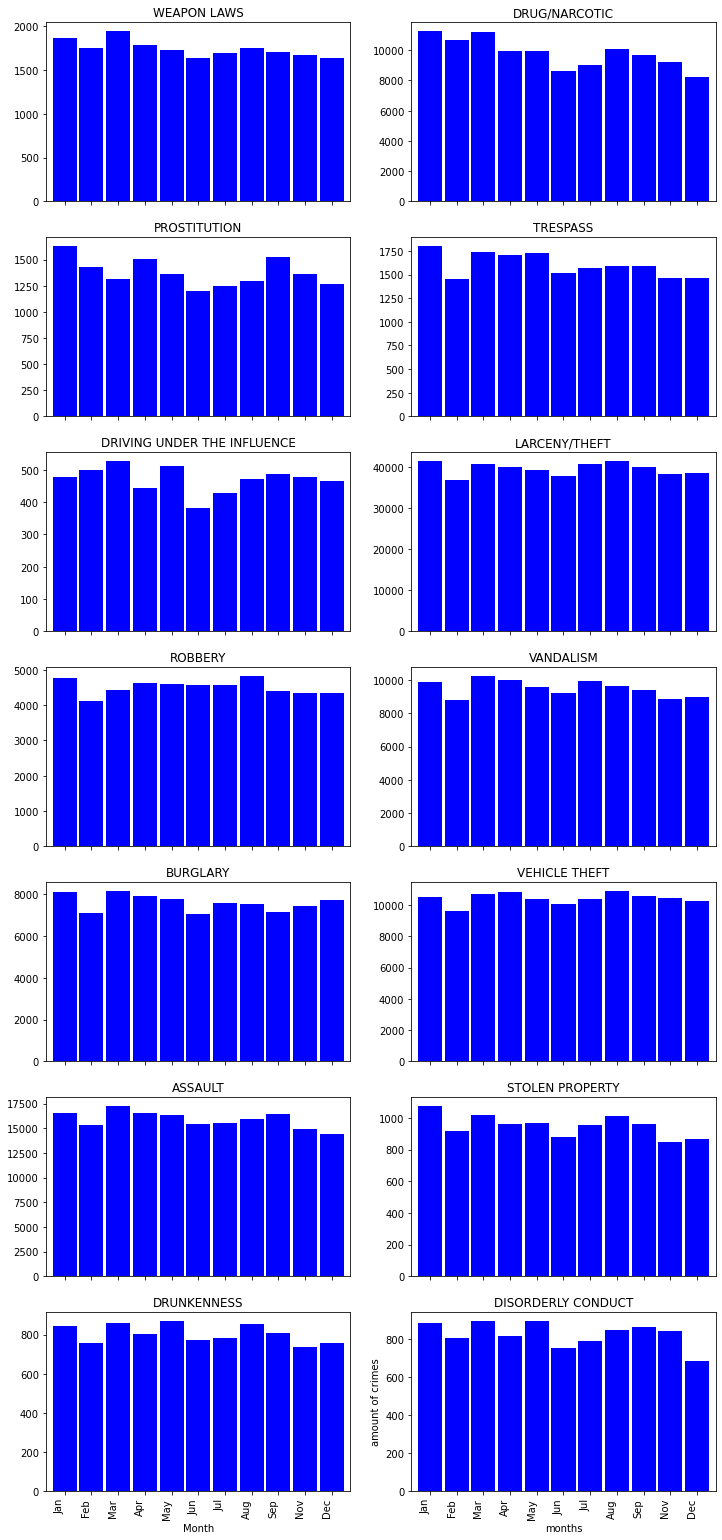

In [2]:
#abbreviated months of the year
month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Nov", "Dec"]

#Data including all types of crimes and the date and month they were reported
crimeByMonth = data.loc[:, ["Category", "Date"]]
crimeByMonth['Date']=pd.to_datetime(data['Date'])
crimeByMonth['Year']=crimeByMonth.Date.dt.year

#remove all data from the year 2018
crimeByMonth.drop([2018], axis=0)

#Change month numbers to abbreviated month names
crimeByMonth['Month']=crimeByMonth.Date.dt.month.apply(lambda x: calendar.month_abbr[x])

#A plot for each crime k in focuscrimes. Double loop to place the plot in a grid of 2 columns and 7 rows

fig, axs = plt.subplots(7,2,figsize=(8,15)) 

k=0                   
for i in range(2):
    for j in range(7):
        typeOfCrime = crimeByMonth.loc[crimeByMonth['Category'] == focuscrimes[k]].groupby("Month").size().reindex(month)
        typeOfCrime.plot(ax=axs[j,i],kind='bar', title=focuscrimes[k], width=0.9, color=['blue'], figsize=(12,30))
        fig.autofmt_xdate(rotation=90)
        plt.ylabel('amount of crimes')
        plt.xlabel('months')
        k=k+1

**The 24 hour cycle**

Displayed below are the focus crimes in the 24 hour cycle. This shows that some crimes occur (or were recorded by police) more often during daytime hours, such as drug/narcotic crimes, whereas others show maximum occurrence during nightime, such as prostitution and driving under the influencde. Others however are likely to ocurr all day long, except a few hours during early morning, such as crimes related to Weapon Laws, Burblary and Assault.
Some crimes, such as Robery and Drunkenness, show a clear constant increasing patern (almost linear) from morning to evening dropping dramaticaly in the early morning hours. On the other hand, Disorderly conduct and Trepassing decrease constantly from morning to evening. Most crimes show minimum occurrence from 5 to 6 a.m.

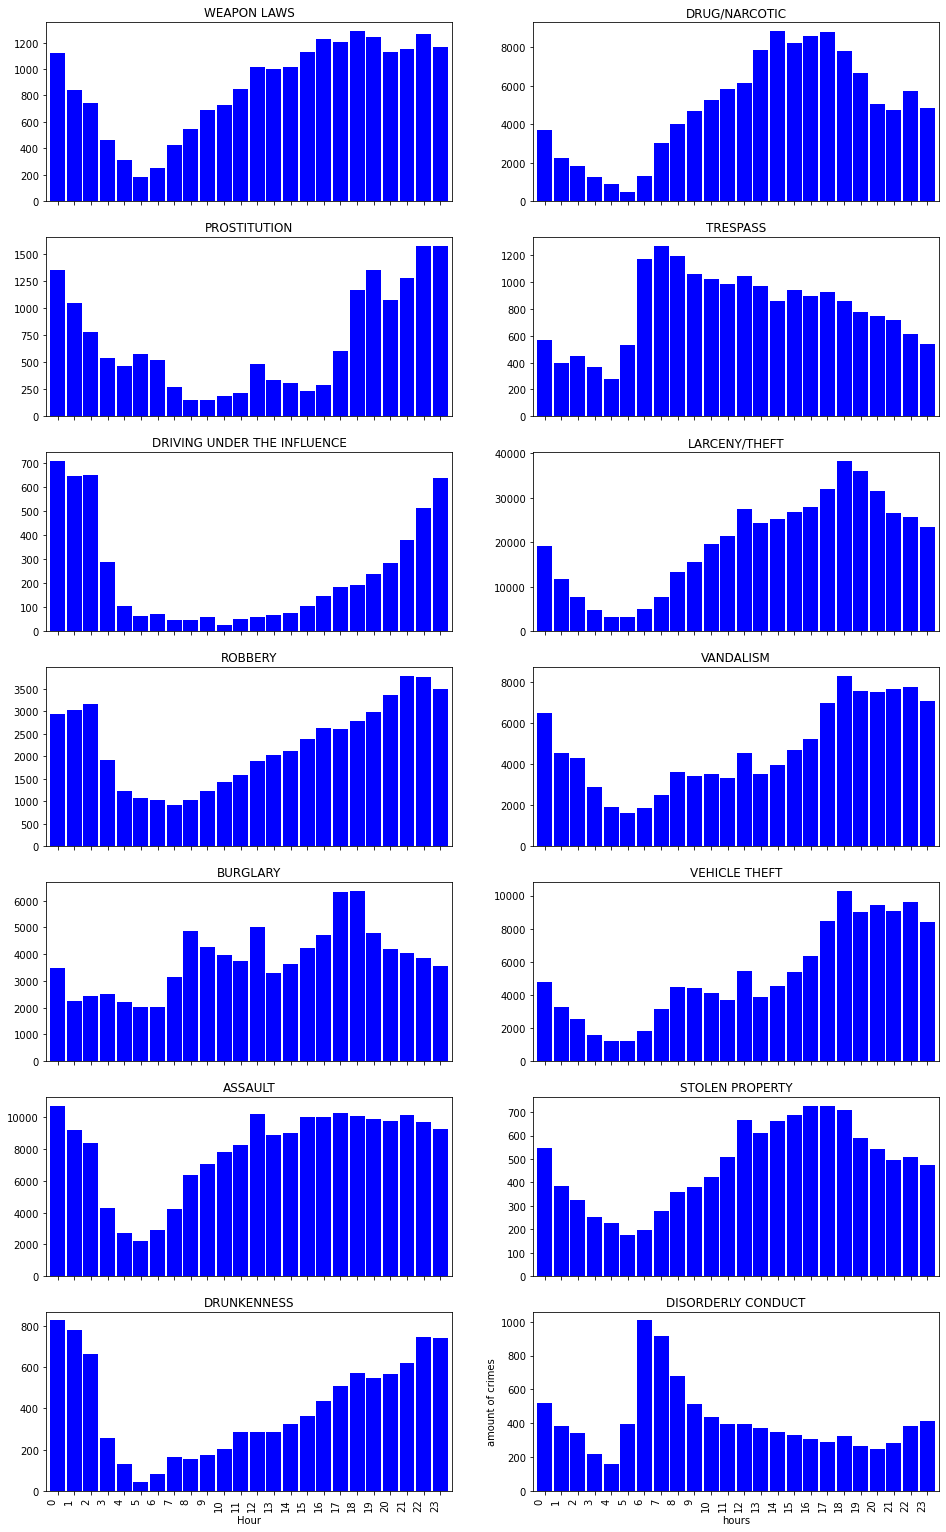

In [3]:
# Data including all types of crimes, the time, date and year the crime was reported
crimeByHour = data.loc[:, ["Category", "Time", "Date"]]

crimeByHour['Date']=pd.to_datetime(data['Date'])
crimeByHour['Time']=pd.to_datetime(data['Time'])

crimeByHour['Hour']=crimeByHour['Time'].dt.hour
crimeByHour['Year']=crimeByHour.Date.dt.year

#remove all data from the year 2018
crimeByHour.drop([2018], axis=0)
    
#A plot for each crime k in focuscrimes. Double loop to place the plot in a grid of 2 columns and 7 rows
fig, axs = plt.subplots(7,2,figsize=(8,15)) 

k=0                   
for i in range(2):
    for j in range(7):
        typeOfCrime = crimeByHour.loc[crimeByHour['Category'] == focuscrimes[k]].groupby("Hour").size()
        typeOfCrime.plot(ax=axs[j,i],kind='bar', title=focuscrimes[k], width=0.9, color=['blue'], figsize=(16,30))
        fig.autofmt_xdate(rotation=90)
        plt.ylabel('amount of crimes')
        plt.xlabel('hours')
        k=k+1

## Part 2: Histograms for Assult and Vehicle Theft

The histograms below display the Assult and Vehicle Theft data as blocks of areas gathered by using latitude part of the GPS coordinates of the crime reports.

There is a clear spike in the Assault histogram and the same place is also very high in the vehicle theft graph. There are clearly very distinct areas where most assults take place while vehicle theft happens evenly. As can be seen on the additional image below the areas where there are spikes an assults also show a great number of vehicle thefts (marked by colors). These could be highly populated areas or frequently visited areas for example areas with a lot of services like shops, bars, clubs and culture.

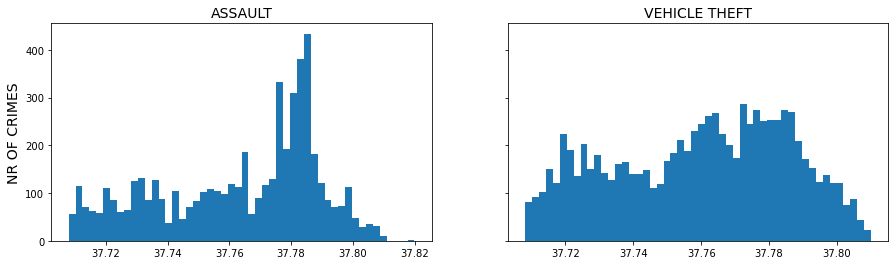

In [4]:
#Data including all types of crimes, the date they were reported and coordinates of where the crime took place
columnsFromData = data.loc[:, ["Category", "X", "Y", "Date"]]
columnsFromData['Date']=pd.to_datetime(data['Date'])

#Filtering out the crimes that happened from the 1st of han 2005 to the 20th of june 2005
crimes=columnsFromData.loc[(columnsFromData['Date'] > '2005-1-1') & (columnsFromData['Date'] <= '2005-6-20')]

#Filtering out the two crimes of interest, Assault and vehicle theft
weaponLaws=crimes.loc[(crimes['Category']=='ASSAULT')]
vehicleTheft=crimes.loc[(crimes['Category']=='VEHICLE THEFT')]

#Displaying the data for both crimes in two sepperate histograms
a=weaponLaws['Y']
b=vehicleTheft['Y']
fig, axs = plt.subplots(1,2, sharey=True)
axs[0].hist(a, bins=50)
axs[1].hist(b, bins=50)
fig.set_figwidth(15)
axs[0].set_title('ASSAULT',fontsize=14)
axs[1].set_title('VEHICLE THEFT',fontsize=14)
axs[0].set_ylabel('NR OF CRIMES',fontsize=14)
plt.show()


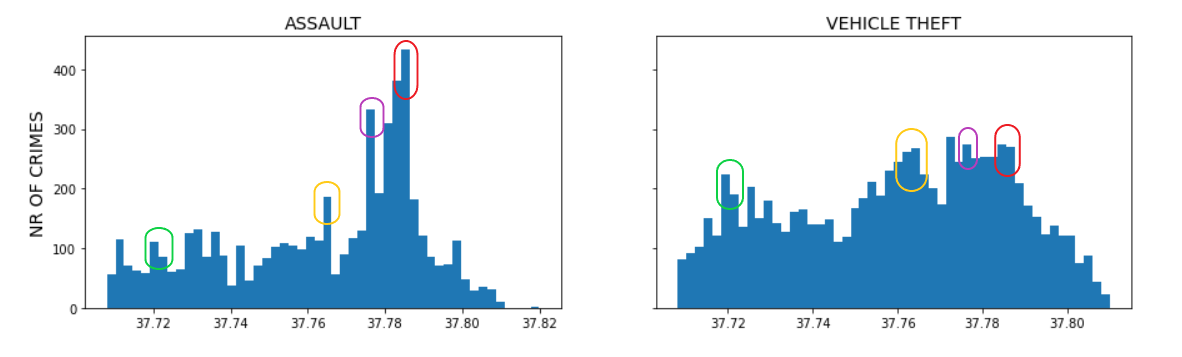

In [5]:
from IPython.display import Image
Image(filename='histogram.png') 

## Part 3: Point Scatter Plot over San Francisco map
**San Francisco map and City Hall marker**

Here is a plot of the map of San Francisco with a nice tight zoom. This is plotted using Folium and including San Francisco's longitude and latitude. Circle markers have been added to the spots where DRUG/NARCOTIC crimes were recorded between June and July 2016. With this map we can identify clusters of crimes in Tenderloin and Mission districts which are downtown San Francisco.

In [6]:
# Select data for DRUG/NARCOTIC, June July
data['date'] = pd.to_datetime(data['Date'])
data_time=data.loc[:,['Category','Date','date','X','Y']]
dataJunJuly=data_time.loc[(data_time['date'] > '2016-6-1') & (data_time['date'] <= '2016-7-20')]
dataDrugNarc=dataJunJuly[dataJunJuly['Category']=='DRUG/NARCOTIC']

# Latitud and Longitud as arrays
lat=np.array(dataDrugNarc['Y'])
lon=np.array(dataDrugNarc['X'])

Map=folium.Map([37.77493, -122.41942],zoom_start=13)

# Marker on Cityhall
folium.Marker([37.77919, -122.41914],
              popup='City Hall',
              icon=folium.Icon(color='green')).add_to(Map)

# Point scatter plot in selected data with a loop
for i in range(len(dataDrugNarc)):
    folium.CircleMarker([lat[i], lon[i]], popup='Drug Crime').add_to(Map)
            
Map

## Part 4: Data visualization

The dataset has been grouped by the focuscrimes and hour of the day. By doing this we are able to follow the 24-hour cycle of each focuscrime.

Then we noramlise the data as each focuscrime has different number of records. This was done by counting the total number of each focuscrime and deviding the hourly number with the total. This results in the percentage of each focuscrime, reported for each hour of the day.

In [7]:
# Data including all types of crimes, the time, date and year the crime was reported
crimeByHour = data.loc[data['Category'].isin(focuscrimes)]
crimeByHour = crimeByHour.loc[:, ["Category", "Time", "Date"]]

#Formatting to datetime
crimeByHour['Date']=pd.to_datetime(crimeByHour['Date'])
crimeByHour['Time']=pd.to_datetime(crimeByHour['Time'])
crimeByHour['Hour']=crimeByHour['Time'].dt.hour
#Getting sum of each focus crime
crimeByHour = crimeByHour.groupby(["Category", "Hour"])["Hour"].sum().reset_index(name ='count')

result = crimeByHour.pivot(index = 'Hour', columns = 'Category', values = 'count')


In [8]:
#Extracting the sum of each focus crime and normalizing the data
for crime in focuscrimes:
    tmp = result[crime].sum()
    result[crime] = result[crime]/tmp

In [9]:
source = ColumnDataSource(result)
hours = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
p = figure(x_range = FactorRange(factors=hours), plot_height=600,plot_width=900, title="Crime counts",
           toolbar_location=None, tools="")
items = []
bar ={}
for indx,i,color in zip(np.arange(0,len(focuscrimes)),focuscrimes,Category20[len(focuscrimes)]):
    bar[i] = p.vbar(x='Hour',  top=i, source= source, color=color,
                 # we will create a vbar for each focuscrime
                  muted_alpha=0.2, muted = True) 
    items.append((i, [bar[i]]))
#i stands for a column that we use, top=y; we are specifying that our numbers comes from column i

# specify how to output the plot
legend = Legend(items = items, location = (0, -30), click_policy = 'mute')
#output_file("crime_counts.html")
p.add_layout(legend, 'left')
p.xaxis.axis_label = "Hour of the day"
p.yaxis.axis_label = "%"
# display the figure
show(p)

The following graph is the output of our bokeh visualization. From this graph we can see that our focus crimes occur more frequently in the evening, spiking between 21-00 and the least activity is happening at night, between midnight and 5AM.

Most of the focuscrime are more frequent during the evening then the day, except for trespassing which is evenly distributed throughout the day. We can see some criminal activty spiking in the late evening, those mainly are Driving under the influence and Prostitution.

We can see that criminal activity is more frequent during the evening and nights. Alcohol and drug related activity are more frequent in the evening, which makes sense as those are the peak hours of the nightlife. Robbery and theft related crimes also occur more 